# 线性回归预测二手车售价

## 本项目的基本框架：
1. 定义问题
2. 收集数据
3. 数据清洗
4. 数据分析及可视化
5. 训练线性回归模型

# 1. 二手车市场是非常庞大且活跃的,每天都有很多成功的交易达成.不仅如此,二手车信息也受到很多购车人士的重视.  
本次项目,主要讨论以下两个问题:
- 二手车的定价和哪些因素有关?
- 如何在二手车数据集上训练线性回归模型.

# 2. 使用爬虫从淘车网采集广州地区的二手车交易信息
囿于篇幅,这里仅提供爬虫的基本思路:
- 设置Agent等头部信息，防止被反爬虫机制拦截
- 抓取二手车品牌名称及对应的链接
- 在元素检查模式下找到剩余所需信息的链接
- 拼接完整链接,对所有链接发送请求
- 发送抓取链接的请求并解析数据
- 导出并储存数据

## 下面导入数据,并查看一下大致信息:

In [1]:
#-*-utf-8-*-
import numpy as np
import pandas as pd

In [2]:
sec_cars = pd.read_csv('sec_cars.csv',encoding='gbk')  #对于中文内容的数据,不能用utf-8解码,需要使用gbk中文解码

In [3]:
#为了不"弄坏"原始数据,我们做一份备份
data = sec_cars.copy()

In [4]:
#先看看数据的大致信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 7 columns):
Brand            597 non-null object
Name             597 non-null object
Boarding_time    597 non-null object
Km               597 non-null object
Discharge        597 non-null object
New_price        597 non-null object
Sec_price        597 non-null float64
dtypes: float64(1), object(6)
memory usage: 32.7+ KB


In [5]:
data.sample(5)

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
432,马自达,马自达6 2008款 轿跑 2.0L 运动型,2008年5月,7.40万公里,国3,21.04万,5.25
323,马自达,马自达6 2007款 2.0L 手自一体豪华型,2006年12月,7.60万公里,国4,20.60万,4.40
332,马自达,马自达6 2008款 轿跑 2.0L 豪华型,2008年8月,6.60万公里,国3,22.77万,4.80
400,马自达,马自达6 2011款 2.0L时尚,2010年10月,8.00万公里,国4,19.52万,7.30
17,本田,雅阁 2007款 2.0L 手动普通版,2006年6月,15.00万公里,国4,21.69万,3.28


数据总共有597条,而且看起来十分完美,没有缺失值?!真的是这样吗?

我们看2条数据,特征Km中有**"百公里内"**这种不规则数据,Discharge中有缺失值(**"--"**),New_price也有缺失值(**"暂无"**)

In [6]:
data.iloc[16:17,:]

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
16,本田,雅阁 2015款 2.0L LX 舒适版,2017年4月,百公里内,国5,19.52万,16.15


In [7]:
data.iloc[232:233,:]

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
232,金杯,阁瑞斯 2010款 睿翔 2.0L 手动 舒适型 短轴7座,2010年9月,8.00万公里,--,暂无,3.58


#### 前面之所以pandas没有识别出缺失值,是因为原始数据的缺失值不是np.nan格式的

# 3. 数据清洗

## 3.1 处理缺失值
- 对于驾驶里程,"百公里内"的数据直接替换成100公里,这是比较合理的选择
- 对于上牌时间和新车价格缺失的,直接从数据集中删除,因为即使用其他值填补,也很难保证是一个好的估计,反而会影响后续的模型训练准确性

In [8]:
data = data.replace('百公里内','0.01万公里')  #直接替换成0.01万公里,方便后续对整列处理

In [9]:
data = data.replace(['--','暂无'],np.nan)  #把缺失值替换成pandas能识别的符号

In [10]:
data.dropna(how='any',inplace=True)  #任何一行,只要有缺失值(其实也只有Discharge和New_price这两列),就地删除该数据

In [11]:
data.info()  #剩下的数据中没有缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 0 to 596
Data columns (total 7 columns):
Brand            557 non-null object
Name             557 non-null object
Boarding_time    557 non-null object
Km               557 non-null object
Discharge        557 non-null object
New_price        557 non-null object
Sec_price        557 non-null float64
dtypes: float64(1), object(6)
memory usage: 34.8+ KB


In [12]:
data = data.reset_index(drop=True)  #重新排列一下索引

## 3.2 处理含有中文的数据

In [13]:
#使用python的str方法,创建一个字符串筛选器,然后用map方法作用到整列
data.New_price = data.New_price.map(lambda x:str(x)[:-1])  #去掉"万"
data.Km = data.Km.map(lambda x:str(x)[:-3])  #去掉"万公里"

In [14]:
#把上面得到的"干净的"字符串数据转成数字型数据
data[['New_price','Km']] = data[['New_price','Km']].apply(pd.to_numeric)

In [15]:
#把原数量单位从以万计转成单位计量,如万元==>元;万公里==>公里
data[['New_price','Sec_price','Km']] = data[['New_price','Sec_price','Km']].apply(lambda x: x *10000.0)

In [16]:
data.sample(3)

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
351,马自达,马自达6 2008款 轿跑 2.0L 运动型,2009年5月,70000.0,国3,210400.0,56700.0
228,金杯,阁瑞斯 2011款 睿翔 2.0L 豪华型 手动 标准顶 长轴 9座,2011年12月,68000.0,国4,174500.0,41800.0
263,马自达,马自达6 2008款 轿跑 2.0L 豪华型,2008年8月,68000.0,国3,227700.0,45000.0


## 3.3 验证数据的正确性
- 如果New_price < Sec_price,则数据肯定是错误的.试问,二手车价格比新车还贵,谁还买二手车呢?

In [17]:
#pandas的列之间不能直接作差,因此使用Series的矢量运算
series1 = data.iloc[:,5]
series2 = data.iloc[:,6]
series = series1 - series2

In [18]:
series.sort_values().head()  #将所得到的结果按升序排列,返回最小的5个值

134    -6500.0
206     1400.0
205     1400.0
135     2700.0
181    22400.0
dtype: float64

竟然真的有这样的**错误数据**存在,让我们看看是哪一条数据:

In [19]:
data.iloc[134:135,:]

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
134,丰田,丰田86 2017款 2.0L 手动 豪华型,2017年4月,6000.0,国5,301500.0,308000.0


这辆车的新车价为301,500元,二手车价格竟然为308,000,不知其中是否有一些二手车手续费之类的费用.但是,为后续分析计,我们直接把这条数据删除.

In [20]:
data = data.drop([134])

In [21]:
data[133:136]  #第134条数据已被删除

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
133,丰田,RAV4荣放 2013款 2.0L 自动 特享精英版,2013年8月,20000.0,国4,238600.0,136000.0
135,丰田,丰田86 2017款 2.0L 手动 豪华型,2016年12月,6000.0,国5,301500.0,298800.0
136,丰田,RAV4荣放 2015款 2.0L CVT 两驱 风尚版,2015年8月,67000.0,国5,216900.0,149800.0


In [23]:
#重新排列一下索引
data = data.reset_index(drop=True)

## 3.4 对分类型数据作标签编码处理

In [24]:
from sklearn.preprocessing import LabelEncoder  #从sklearn包导入标签编码工具,该工具将各标签从0开始编码

label = LabelEncoder()

for x in data:
    data.Discharge = label.fit_transform(data.Discharge)

#编码后,国2标准会变成0,为了消除影响,对每个编码后的数值加1,使得各样本下的该特征都不被后面的线性回归模型忽略
data.Discharge = data.Discharge.apply(lambda x: x+1)

In [25]:
data.sample(3)  #可以看到,Discharge现在都是纯数字

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
533,雪佛兰,迈锐宝 2013款 2.0L 手自一体 豪华版,2013年3月,52800.0,4,197400.0,100000.0
400,马自达,马自达6 2013款 2.0L 手动型,2013年11月,30000.0,6,140900.0,78100.0
2,宝马,宝马3系(进口) 2012款 四门轿车 318i 2.0L A/MT,2011年12月,70000.0,4,377700.0,136000.0


## 3.5 处理中文型日期

In [26]:
#先构造一个字符串方法,拼接字符,只保留数字,去除"年"和"月",把类似2012年12月变成2012-12-1
data.Boarding_time = data.Boarding_time.map(lambda x:str(x)[:4] +'-'+str(x)[5:-1]+'-'+str(1))

In [27]:
data.sample(1)

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
382,马自达,马自达5 2011款 2.0L 自动 豪华型,2010-7-1,60000.0,4,208200.0,98000.0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 7 columns):
Brand            556 non-null object
Name             556 non-null object
Boarding_time    556 non-null object
Km               556 non-null float64
Discharge        556 non-null int64
New_price        556 non-null float64
Sec_price        556 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 30.5+ KB


#### Boarding_time,即上牌日期现在是一个类似标准日期的字符串,'2009-8-1',下面使用pandas的Timestamp()方法转换成真正的日期格式

In [29]:
data.Boarding_time = data.Boarding_time.map(lambda x:pd.Timestamp(x))

In [30]:
data.sample(1)

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price
244,马自达,马自达6 2007款 2.0L 手自一体超豪华型,2007-05-01,76000.0,4,216900.0,42000.0


## 3.6 创建新特征

#### 根据上牌日期,创建一个新特征,例如以2002-01-01作为基准,计算中间的日期数,则对于各款车来说,这个日期数越大,说明车越新,相应地,其价格应该越高.

In [31]:
#创建基准日期
data['day_base'] = pd.Timestamp('20020101')

In [32]:
#创建新特征,计算日期数
data['Board_days'] = (data.Boarding_time - data.day_base).dt.days

In [33]:
data.sample(3)

,Brand,Name,Boarding_time,Km,Discharge,New_price,Sec_price,day_base,Board_days
463,起亚,狮跑 2013款 2.0L 手动 两驱 GLS,2013-10-01,70600.0,4,134400.0,79000.0,2002-01-01,4291
239,马自达,阿特兹 2015款 2.0L 蓝天尊贵版,2016-01-01,12000.0,6,223400.0,155000.0,2002-01-01,5113
418,马自达,马自达6 2008款 轿跑 2.0L 豪华型,2008-10-01,68000.0,2,227700.0,48000.0,2002-01-01,2465


## 3.7 删除无效的特征
- Brand,Name 这样的品牌名称对后续的分析无用,可以删除
- Boarding_time,day_base已经被压缩为Board_days,可以删除

In [34]:
data = data.drop(['Brand','Name','Boarding_time','day_base'],axis=1)  #在列方向删除

In [35]:
#对剩余的特征排列顺序重新整理
data = data.reindex(columns = ['New_price','Km','Discharge','Board_days','Sec_price'])
data.sample(3)

,New_price,Km,Discharge,Board_days,Sec_price
333,195200.0,63900.0,3,2708,48800.0
370,206000.0,88000.0,4,2981,62000.0
105,139800.0,79200.0,4,3438,56800.0


#### 通过观察,我们看到上面的各个特征,New_price的量级是10<sup>6</sup>,而Discharge的量级是10<sup>0</sup>,这种数据训练出来的线性模型具有非常大的误差,且各系数大小差距非常大.需要做归一化处理,这里我们采用(0-1)处理.

## 3.8 对数据作归一化处理,压缩到[0,1]

In [36]:
data = data.apply(lambda x: (x - np.min(x))/(np.max(x)-np.min(x)))
data.sample(5)

,New_price,Km,Discharge,Board_days,Sec_price
35,0.397111,0.163256,0.6,0.527659,0.236082
368,0.358338,0.417917,0.4,0.360278,0.108527
198,0.091485,0.285584,0.6,0.521943,0.070472
335,0.358338,0.372442,0.6,0.235762,0.094433
254,0.358338,0.386085,0.6,0.192488,0.070472


### 到此数据清洗部分结束

# 4. 数据可视化

Text(0.5,1,'Board_days vs Sec_price')

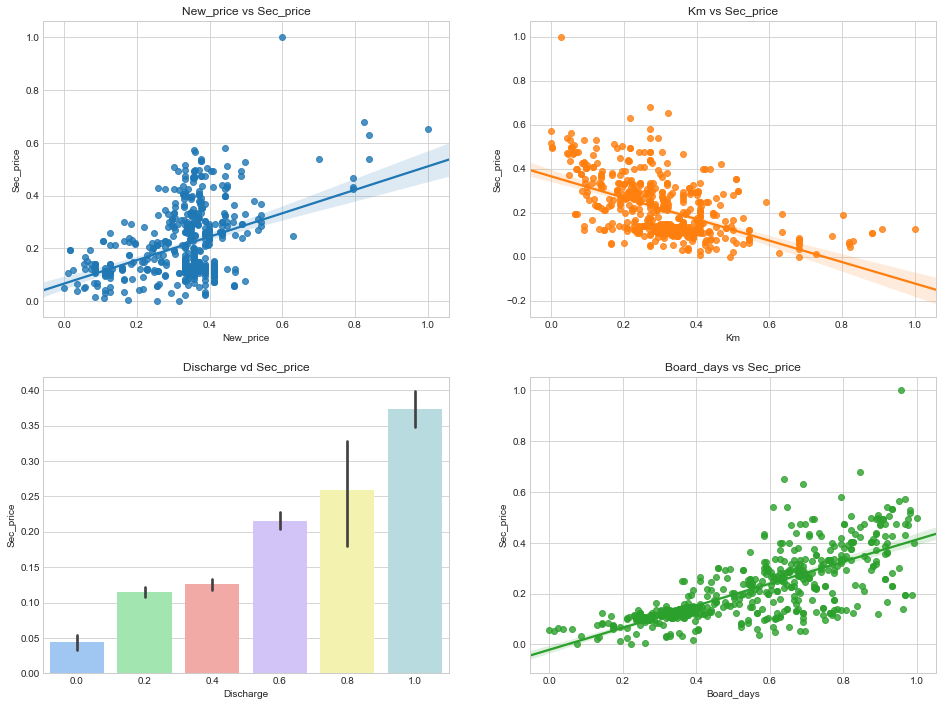

In [38]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#定制图形展示参数
%matplotlib inline 

#设置子图的个数以及画布的大小
fig,saxis = plt.subplots(2,2,figsize=(16,12))

#定制配色方案
current_palette = sns.color_palette("pastel")

#定制画布的主题
current_style = sns.set_style('whitegrid')


sns.regplot(x = 'New_price',y = 'Sec_price',data = data,ax = saxis[0,0]).set_title('New_price vs Sec_price')
sns.regplot(x = 'Km',y = 'Sec_price',data = data,ax = saxis[0,1]).set_title('Km vs Sec_price')
sns.barplot(x = 'Discharge',y = 'Sec_price',data = data,palette=current_palette,ax = saxis[1,0]).set_title('Discharge vd Sec_price')
sns.regplot(x = 'Board_days',y = 'Sec_price',data = data,ax = saxis[1,1]).set_title('Board_days vs Sec_price')

#### 上面是一个简单的数据可视化,可以看出:
- New_price,Discharge,Board_days这三个特征和Sec_price是一种正相关
- Km和Sec_price是一种负相关  

由于数据的可用特征较少,数据分析部分就不再展开详细讨论,给出下面的**相关性热图**作为参考:

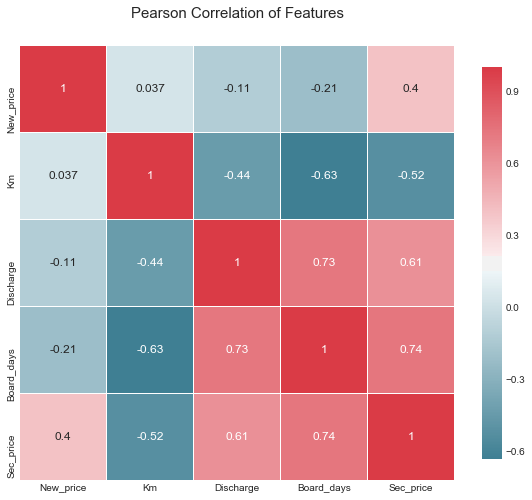

In [39]:
#相关性heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize = (10,8))
    colormap = sns.diverging_palette(220,10,as_cmap = True)
    
    _ = sns.heatmap(df.corr(),cmap=colormap,square=True,cbar_kws={'shrink':0.9},ax=ax,annot=True,linewidths=0.1,vmax=1.0,linecolor='white',annot_kws={'fontsize':12})
    plt.title("Pearson Correlation of Features", y = 1.05, size = 15)
    
correlation_heatmap(data)

# 5. 训练线性回归模型

#### 我们将使用4个特征: New_price, Km, Discharge, Board_days
模型的方程为: **Sec_price = W<sub>0</sub>\*New_price + W<sub>1</sub>\*Km + W<sub>2</sub>\*Discharge + W<sub>3</sub>\*Board_days**

In [40]:
#分割数据集,80%的数据作为训练集
from sklearn.model_selection import train_test_split

dataMat = data.iloc[:,:-1];labelMat = data.iloc[:,-1]

train_x,test_x,train_y,test_y = train_test_split(dataMat,labelMat,test_size = 0.2,random_state=42)

In [41]:
def standRegres(xArr,yArr):
    '''
    线性回归函数
    Args:
        xArr：输入的样本数据，包含每个样本的特征，就是上面的dataMat内容
        yArr：输入的样本标签，包含每个样本的标签，就是上面的labelMat内容
    Returns：
        w：回归系数向量
    '''
    #mat()函数将xArr,yArr转换为矩阵，mat().T是对应的转置操作
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    #矩阵乘法
    xTx = xMat.T * xMat
    #因为要用到xTx的逆矩阵，所以需要先计算该矩阵的行列式，值不为0方可
    #np.linalg.det()函数即是用来计算行列式的
    if np.linalg.det(xTx) == 0.0:
        print("这个矩阵是奇异的，没有逆矩阵")
        return
    #否则，说明存在逆矩阵，可以接着用最小二乘法求出最后的结果，[（xTx)^-1](xT*y)
    w = xTx.I * (xMat.T * yMat)
    return w

if __name__ == '__main__':
    xArr,yArr = train_x,train_y
    w = standRegres(xArr,yArr)
    print(w)

[[ 0.42305123]
 [-0.29257494]
 [ 0.04747121]
 [ 0.2644909 ]]


In [42]:
#下面使用sklearn包训练并验证模型
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(xArr,yArr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
reg.coef_

array([ 0.65821913, -0.01379558,  0.0600377 ,  0.46363971])

In [44]:
reg.intercept_

-0.28738787250542019

#### 由于我们的手写代码中,没分配b这项,因此求得的回归系数和sklearn算法求得的系数有所不同.  

下面使用测试集验证模型的准确率

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg,train_x,train_y,cv=5)

In [46]:
scores

array([ 0.896168  ,  0.89461945,  0.8411946 ,  0.819862  ,  0.8859549 ])

In [47]:
print('accuracy:{0:.2f}% +/-{1:.2f}%'.format(scores.mean()*100,scores.std()*300))

accuracy:86.76% +/-9.35%


In [48]:
scores1 = cross_val_score(reg,test_x,test_y,cv=10)
print('accuracy:{0:.2f}% +/-{1:.2f}%'.format(scores1.mean()*100,scores1.std()*300))

accuracy:82.61% +/-24.55%


#### 模型效果:
- 在训练集上的准确率为86.76%,三个标准差置信区间浮动在+/-9.35%,最差准确率为77.41%
- 在测试集上的准确率为82.61%,三个标准差置信区间浮动在+/-24.55%,最差准确率为58.06%

可见,我们的模型有点偏向过拟合,对于过拟合,原本需要减少特征(参数)个数,降低模型复杂度.但是由于我们的数据本来只有4个特征可用,因此不宜再缩减特征.可以考虑使用局部加权线性回归,针对各特征赋予恰当的权重,平衡模型在训练集和测试集上的表现.具体实现不在此处展开.